In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
buildingo = pd.read_csv('Building_Ownership_Use.csv')
buildingc = pd.read_csv('Building_Structure.csv')
test = pd.read_csv('test.csv')

In [3]:
train.groupby("damage_grade")['damage_grade'].value_counts()

damage_grade  damage_grade
Grade 1       Grade 1          61320
Grade 2       Grade 2          85084
Grade 3       Grade 3         122288
Grade 4       Grade 4         152244
Grade 5       Grade 5         210825
Name: damage_grade, dtype: int64

In [4]:
combin = pd.concat([train, test])

/home/tinku/.virtualenvs/cv/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
combin = pd.merge(left = combin, right = buildingo, on = ['building_id','vdcmun_id', 'district_id'] )

In [6]:
combin = pd.merge(left = combin, right = buildingc, on = ['building_id','vdcmun_id', 'district_id', 'ward_id'] )

In [7]:
del( buildingo, buildingc)

In [9]:
combin_na = (combin.isnull().sum()/len(combin))
combin_na = combin_na.drop(combin_na[combin_na==0].index).sort_values(ascending = False)*100
missing_data = pd.DataFrame({'Missing': combin_na})
missing_data

,Missing
damage_grade,40.000057
has_repair_started,5.255685
count_families,0.000095


In [20]:
combin['has_repair_started'].value_counts()

0.0    682263
1.0    315334
Name: has_repair_started, dtype: int64

In [21]:
combin['count_families'].value_counts()

1.0     913095
0.0      84304
2.0      46244
3.0       7075
4.0       1618
5.0        413
6.0        128
7.0         33
8.0         16
9.0          8
11.0         1
Name: count_families, dtype: int64

In [22]:
combin.count_families.fillna(1, inplace = True)
combin.has_repair_started.fillna(0, inplace = True)

In [29]:
combin.area_assesed.unique()
pd.crosstab(train['damage_grade'], train['area_assesed']).apply(lambda x: (x/x.sum())*100, axis = 0)
combin['area_assesed'].value_counts()
combin['area_assesed_count'] = combin.groupby('area_assesed')['area_assesed'].transform('count')

area_assesed,Both,Building removed,Exterior,Interior,Not able to inspect
damage_grade,,,,,
Grade 1,54020,130,6714,263,193
Grade 2,77827,175,6680,324,78
Grade 3,111187,266,10166,503,166
Grade 4,118108,514,31867,570,1185
Grade 5,21850,130261,43603,158,14953


In [30]:
combin.drop('building_id', axis = 1, inplace = True)

In [31]:
combin['district_id_count'] = combin.groupby('district_id')['district_id'].transform('count')

In [32]:
combin['vdcmun_id_count'] = combin.groupby('vdcmun_id')['vdcmun_id'].transform('count')

In [33]:
combin['ward_id_count'] = combin.groupby('ward_id')['ward_id'].transform('count')

In [34]:
combin['district_vdcmun_count'] = combin.groupby(['district_id', 'vdcmun_id'])['district_id'].transform('count')

In [35]:
combin['district_ward_vdc_count'] = combin.groupby(['district_id', 'vdcmun_id', 'ward_id'])['district_id'].transform('count')

In [36]:
combin['floor_gap'] = ( combin['count_floors_pre_eq'] - combin['count_floors_post_eq'])
combin['height_gap'] = ( combin['height_ft_pre_eq'] - combin['height_ft_post_eq'])

In [37]:
combin['land_surface_condition_district'] = combin.groupby(['land_surface_condition', 'district_id'])['district_id'].transform('count')
combin['condition_post_district'] = combin.groupby(['condition_post_eq', 'district_id'])['district_id'].transform('count')

In [38]:
combin['condition_post_district_vdc_ward'] = combin.groupby(['condition_post_eq', 'district_id', 'vdcmun_id', 'ward_id'])['district_id'].transform('count')

In [39]:
combin['area_district'] = combin.groupby(['area_assesed', 'district_id'])['district_id'].transform('count')

In [40]:
combin['area_district_vdc_ward'] = combin.groupby(['area_assesed', 'district_id', 'vdcmun_id', 'ward_id'])['district_id'].transform('count')

In [47]:
#combin = combin.drop(['district_id'], axis = 1)
combin['district_id'] = combin['district_id'].astype('category')

In [45]:
combin = combin.drop(['vdcmun_id'], axis = 1)

In [46]:
combin = combin.drop(['ward_id'], axis = 1)

In [48]:
train2 = combin[combin.damage_grade.isnull() == False]
test2 = combin[combin.damage_grade.isnull() == True]
del(combin)

In [49]:
test2 = test2.drop(['damage_grade'], axis = 1)

In [50]:
X = train2.drop(['damage_grade'], axis = 1)
X = pd.get_dummies(X, drop_first=True)
test2 = pd.get_dummies(test2, drop_first=True)
y = train2['damage_grade']

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

In [54]:
import lightgbm as lgb
dtrainlgb = lgb.Dataset(data = X_train, label = y_train)
params = {'objective': 'softmax',
         'learning_rate' : 0.2,
          'num_class' : 5,
          'num_leaves' : 60}
cv_results = lgb.cv(params,
                    dtrainlgb,
                    num_boost_round = 1000,
                    nfold = 3,
                    metrics = 'multi_error',
                    early_stopping_rounds = 20,
                    verbose_eval = 5)           #600 iterations

[5]	cv_agg's multi_error: 0.272368 + 0.000660517
[10]	cv_agg's multi_error: 0.267109 + 0.000567317
[15]	cv_agg's multi_error: 0.263111 + 0.000630247
[20]	cv_agg's multi_error: 0.259321 + 0.000329886
[25]	cv_agg's multi_error: 0.255536 + 0.000392543
[30]	cv_agg's multi_error: 0.252772 + 0.0002861
[35]	cv_agg's multi_error: 0.250516 + 0.00023811
[40]	cv_agg's multi_error: 0.248571 + 0.00032078
[45]	cv_agg's multi_error: 0.246703 + 0.000405065
[50]	cv_agg's multi_error: 0.245344 + 0.000383403
[55]	cv_agg's multi_error: 0.244089 + 0.000371928
[60]	cv_agg's multi_error: 0.243033 + 0.00032804
[65]	cv_agg's multi_error: 0.242092 + 0.000610943
[70]	cv_agg's multi_error: 0.241285 + 0.000538297
[75]	cv_agg's multi_error: 0.240268 + 0.000273724
[80]	cv_agg's multi_error: 0.24006 + 0.000582104
[85]	cv_agg's multi_error: 0.238927 + 0.000373144
[90]	cv_agg's multi_error: 0.238384 + 0.000140842
[95]	cv_agg's multi_error: 0.237769 + 0.000308771
[100]	cv_agg's multi_error: 0.237029 + 0.000210028
[105]	

In [55]:
lgb_model = lgb.train(params,
                     dtrainlgb,
                     num_boost_round = 465,
                     verbose_eval = True)

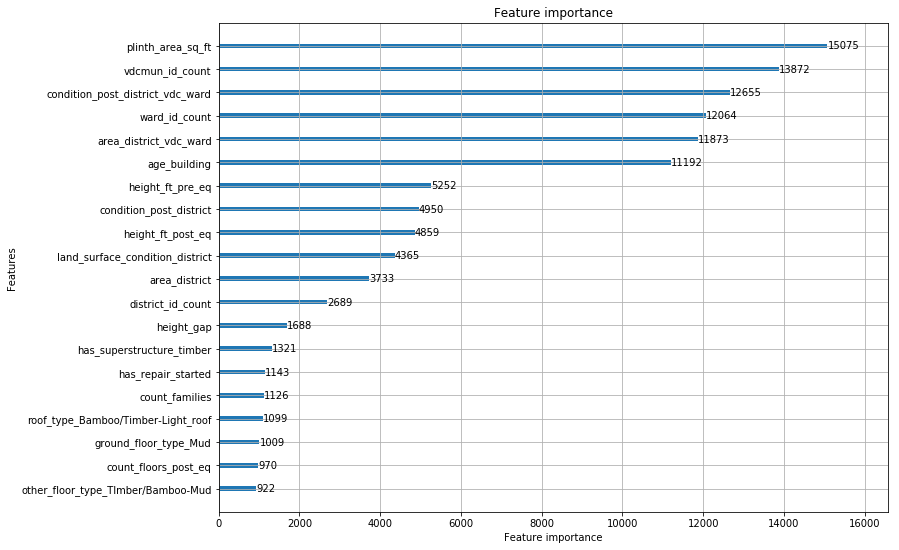

In [57]:
import matplotlib.pyplot as plt
a = lgb.plot_importance(lgb_model, max_num_features=20, height=.2, figsize=(12,9))
plt.show()

In [58]:
lgb_pred = lgb_model.predict(X_test)

In [59]:
dataf = pd.DataFrame(lgb_pred)

In [60]:
dataf.head()

,0,1,2,3,4
0,3.603146e-11,3.481566e-11,9.835219e-10,1.889250e-08,1.000000e+00
1,2.716278e-02,1.284750e-01,4.247448e-01,4.194176e-01,1.997881e-04
2,5.786328e-03,1.124318e-01,7.076788e-01,1.733142e-01,7.889515e-04
3,1.277268e-09,1.251337e-09,3.121074e-08,9.056234e-07,9.999991e-01
4,9.999680e-01,2.622361e-05,2.778358e-06,3.024974e-06,1.365941e-08


In [61]:
dataf['max_col'] = dataf.idxmax(axis=1)

In [64]:
dataf.head()

,0,1,2,3,4,max_col,class
0,3.603146e-11,3.481566e-11,9.835219e-10,1.889250e-08,1.000000e+00,4,Grade 5
1,2.716278e-02,1.284750e-01,4.247448e-01,4.194176e-01,1.997881e-04,2,Grade 3
2,5.786328e-03,1.124318e-01,7.076788e-01,1.733142e-01,7.889515e-04,2,Grade 3
3,1.277268e-09,1.251337e-09,3.121074e-08,9.056234e-07,9.999991e-01,4,Grade 5
4,9.999680e-01,2.622361e-05,2.778358e-06,3.024974e-06,1.365941e-08,0,Grade 1


In [63]:
dataf['class'] = 'Grade 1'
dataf.loc[dataf['max_col'] == 1, 'class'] = 'Grade 2'
dataf.loc[dataf['max_col'] == 2, 'class'] = 'Grade 3'
dataf.loc[dataf['max_col'] == 3, 'class'] = 'Grade 4'
dataf.loc[dataf['max_col'] == 4, 'class'] = 'Grade 5'

In [65]:
from sklearn.metrics import f1_score
accu = f1_score(y_test, dataf['class'], average='weighted')

In [66]:
accu

0.7801319428295673

In [67]:
submit = lgb_model.predict(test2)


In [68]:
submit2 = pd.DataFrame(submit)

In [69]:
submit2.head()
submit2['max_col'] = submit2.idxmax(axis=1)

In [70]:
submit2['class'] = 'Grade 1'
submit2.loc[submit2['max_col'] == 1, 'class'] = 'Grade 2'
submit2.loc[submit2['max_col'] == 2, 'class'] = 'Grade 3'
submit2.loc[submit2['max_col'] == 3, 'class'] = 'Grade 4'
submit2.loc[submit2['max_col'] == 4, 'class'] = 'Grade 5'

In [71]:
output = pd.DataFrame({'building_id': test.building_id, 'damage_grade' : submit2['class']})
output.to_csv('output.csv', index=False)